In [5]:
import pandas as pd
import numpy as np

# 데이터 전처리 (data_preprocessing.ipynb)

In [6]:
# Read Data
df = pd.read_excel("../data/train.xlsx")

In [7]:
# 년/월/일 분리(split) + 요일(Weekday) 추가
def split_date(df):
    # Normalize Date
    df['year'] = (df['일자'] / 10000).astype(int)
    df['month'] = (df['일자'] % 10000 / 100).astype(int)
    df['day'] = (df['일자'] % 100).astype(int)
    df['weekday'] = pd.to_datetime(df['일자'], format = '%Y%m%d').dt.dayofweek
    df.drop(['일자'], axis=1, inplace=True)

In [8]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d


In [9]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]

In [10]:
# 식사명 변환 (one-hot)
def convert_ont_hot(df):
    df = df.join(pd.get_dummies(df['식사명'], prefix='식사명'))
    df.drop(['식사명'], axis=1, inplace=True)
    return df

In [11]:
# 식사내용 변환 (Bag-of-Word)
from sklearn.feature_extraction.text import CountVectorizer
def tokenize(text):
        return text.split(',')
def convert_bow(df):
    vectorizer = CountVectorizer(tokenizer=tokenize)
    bow = vectorizer.fit_transform(df['식사내용']).toarray()
    df = df.join(pd.DataFrame(bow, columns=vectorizer.get_feature_names()))
    df.drop(['식사내용'], axis=1, inplace=True)
    return df

In [12]:
# Read Data
df = pd.read_excel("../data/train.xlsx")

In [13]:
# Date
split_date(df)
add_lunar_date(df)

# Date Normalization
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [14]:
# convert 식사명 to one-hot
df = convert_ont_hot(df)

# convert 식사내용 to Bag-of-Word Vector
df = convert_bow(df)

In [15]:
print("Number of Columns =", len(df.columns))
df.head()

Number of Columns = 1892


,수량,year,weekday,lunar_year,month_sin,month_cos,lunar_month_sin,lunar_month_cos,day_sin,day_cos,...,휘),흑미밥,흑미밥(현장),흑임자밥,흑임자죽,흑콩견과류조림,흑콩밥,흑콩조림,흰죽,흰콩곤약조림
0,37.472924,0.0,5,0.0,1.0,6.123234e-17,0.5,0.866025,0.201299,0.979530,...,0,0,0,0,0,0,0,0,0,0
1,19.566787,0.0,5,0.0,1.0,6.123234e-17,0.5,0.866025,0.201299,0.979530,...,0,0,0,0,0,0,0,0,0,0
2,31.191336,0.0,5,0.0,1.0,6.123234e-17,0.5,0.866025,0.201299,0.979530,...,0,0,0,0,0,0,0,0,0,0
3,36.101083,0.0,6,0.0,1.0,6.123234e-17,0.5,0.866025,0.394356,0.918958,...,0,0,0,0,0,0,0,0,0,0
4,21.949458,0.0,6,0.0,1.0,6.123234e-17,0.5,0.866025,0.394356,0.918958,...,0,0,0,0,0,0,0,0,0,0


# Modeling

1. Random Forest
2. XGBoost

## 0. Prepare train & test

#### 1) Split train and test(validation) set by 8 to 2

In [16]:
from sklearn.model_selection import train_test_split
train_df, dev_df = train_test_split(df, test_size=0.2, random_state=10)
print(train_df.shape)
print(dev_df.shape)

(16008, 1892)
(4002, 1892)


In [17]:
train_y = train_df['수량']
train_x = train_df.drop(['수량'], axis=1)
dev_y = dev_df['수량']
dev_x = dev_df.drop(['수량'], axis=1)

#### 2) train, predict, evaluation function (반복적으로 사용되는 코드이므로)

In [18]:
from sklearn.metrics import mean_squared_error
import math

def train_and_predict(model, train_x, train_y, dev_x):
    model.fit(train_x, train_y)
    return model.predict(dev_x)

def evaluate(predict_y, actual_y):
    rmse = math.sqrt(mean_squared_error(actual_y, predict_y))
    print('RMSE :', round(np.mean(rmse), 4))

## 1. Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 100, random_state = 10)

In [32]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 4.7806
CPU times: user 2min 23s, sys: 1.48 s, total: 2min 25s
Wall time: 2min 26s


## 2. XGBoost

In [34]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.05, 
                         max_depth=15,
                         colsample_bytree=0.9,
                         gamma=0.4,
                         min_child_weight=7,
                         subsample=0.9,
                         reg_alpha=0.1,
                         seed=10)

In [35]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 4.6454
CPU times: user 12min 9s, sys: 5.27 s, total: 12min 14s
Wall time: 12min 22s


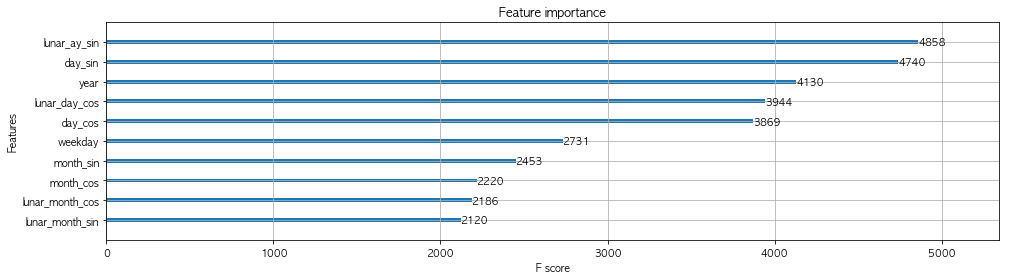

In [36]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

plt.rcParams['figure.figsize'] = (16,4)
plt.rcParams['font.family'] = 'AppleGothic'

xgb.plot_importance(model, max_num_features=10)

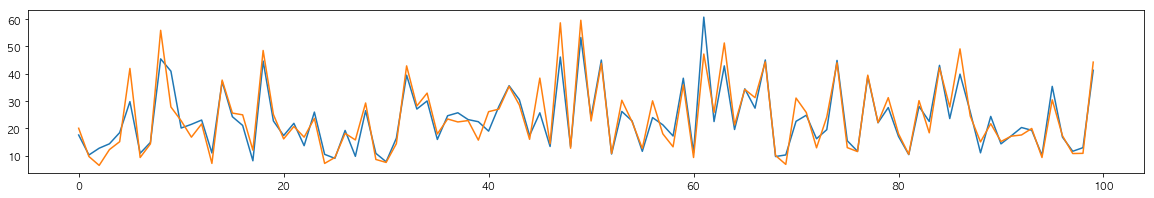

In [37]:
plt.rcParams["figure.figsize"] = (20,3)
index = 500

plt.plot(pred[index:index+100])
plt.plot(dev_y.values[index:index+100])